In [14]:
import numpy as np
from Library import Convert_to_A_and_B, ka, truncate, Create_MPO, Create_random_MPS, Pauli, Model_coefficients

def H_mult(v):
    return np.matmul(H,v)

def Exp_value_B(B, L, W, chi_MPO):
  v_L,v_R = np.zeros(chi_MPO,dtype=np.complex_), np.zeros(chi_MPO,dtype=np.complex_)
  v_L[0],v_R[-1]=1.+0j, 1.+0j
  Env = np.einsum("a,b,c->abc",B[0],v_L,B[0])
  
  for j in range(1,L+1):
    Env = np.einsum("abc,ajd->djbc",Env,B[j])
    Env = np.einsum("djbc,beji->deic",Env,W)
    Env = np.einsum("deic,cif->def",Env,np.conj(B[j]))
  Energy = np.einsum("ded,e->",Env,v_R)
  return Energy.real

In [15]:
from numpy import linalg as LA
from quspin.basis import spin_basis_1d 
from quspin.operators import hamiltonian # Hamiltonians and operators
from scipy.sparse.linalg import eigsh
from scipy.sparse.linalg import LinearOperator
import matplotlib.pyplot as plt

data_type=np.complex128
S_z, S_x, S_y, S1 = Pauli()

d = 2
L = 80        # system size
chi_max = 10          # Maximal bond dimension                            
n = 10   # Number of zips
h_x, h_y, h_z = 0.5, 0.9, 0.5  # Field in the different directions
J_xx, J_yy, J_zz = 1.5, 0.2, 1.5  # Strength of spin interactions
Model = [["z"],["x"]]     # The first part of the model gives us the spin interaction and the second one the fields
chi_MPO = len(Model[0]) + 2 
t = 15

Interactions, Fields = Model_coefficients(J_xx,J_yy,J_zz,h_x,h_y,h_z)
          
chis = ka(L,chi_max)
# Create MPO
W = Create_MPO(Model, S1, Interactions, Fields, chi_MPO, data_type)
# Create the MPS
Gamma,Lambda = Create_random_MPS(L,chis)
# Convert to right and left A,B canonical form
A,B = Convert_to_A_and_B(Gamma,Lambda,L)

# Left and Right vectors
v_L,v_R=np.zeros(chi_MPO,dtype=np.complex_),np.zeros(chi_MPO,dtype=np.complex_)
v_L[0],v_R[-1]=1.+0j,1.+0j

# Initialise Left and Right environments
L_env=[np.zeros((chis[j],chi_MPO,chis[j]),dtype=np.complex_)for j in range(L)]
R_env=[np.zeros((chis[j+1],chi_MPO,chis[j+1]),dtype=np.complex_)for j in range(L)]

L_env[0]=np.einsum("ab,c->acb",np.eye(chis[0],dtype=np.complex_),v_L)
R_env[-1]=np.einsum("ab,c->acb",np.eye(chis[-1],dtype=np.complex_),v_R)

# Set the Right environment
for j in range(L-1,0,-1):
    R_env[j-1]=np.einsum("dja,ebji->debia",B[j+1],W)
    R_env[j-1]=np.einsum("debia,fic->debfca",R_env[j-1],np.conj(B[j+1]))
    R_env[j-1]=np.einsum("debfca,abc->def",R_env[j-1],R_env[j])
print("Initiated right environment")
# Calculating the inverse of the singular values 
vi=[]
for j in range(len(Lambda)):
  vi.append(np.divide(1.0, Lambda[j], out=np.zeros_like(Lambda[j]), where=np.abs(Lambda[j])>=1E-14))
vi.append([1.])
sluchaino = Lambda[L//2][0:chi_max]

Initiated right environment


In [16]:
#DMRG cycle
delta = 3
step = 0
energy = Exp_value_B(B, L, W, chi_MPO)

while np.abs(delta)>10E-9 and step<30:
   print("DMRG step:",step)
   #Right sweep
   for j in range(L-2):
    # Evaluate the Hamiltonian
    H = np.einsum("abc,bdij->adijc",L_env[j],W) 
    H = np.einsum("adijc,dekl->aekl ijc",H,W)
    H = np.einsum("aekl ijc,feg->aikf cjlg",H,R_env[j+1]).reshape((chis[j]*chis[j+2]*d**2,chis[j]*chis[j+2]*d**2))

    # Calculate the eigenvalues and eigenvectors
    O = LinearOperator((chis[j]*chis[j+2]*d**2,chis[j]*chis[j+2]*d**2), matvec=H_mult)
    Theta = np.einsum("a,aib->aib",Lambda[j],B[j+1])
    Theta = np.einsum("aib,bjc->aijc",B[j+1],B[j+2]).reshape(chis[j]*chis[j+2]*d**2)
    
    # Find the ground state
    w, v = eigsh(O,k=1,v0=Theta,which="SA",maxiter = 1000000)
 
    # Compute the new 2-site Wave Function
    Theta_p = v[:,0].reshape(chis[j]*d,chis[j+2]*d)

    # Truncate the wave function
    Sigma,lam,D = truncate(j,Theta_p,chis,L,d=2)
    
    # Update A
    A[j] = Sigma
    Lambda[j+1] = lam

    vi[j+1] = np.divide(1.0, lam, out=np.zeros_like(lam), where=np.abs(lam)>=1E-14)

    # Update sites j+1
    A[j+1] = np.einsum("a,aib,b->aib",lam,D,vi[j+2])
    B[j+1] = np.einsum("a,aib,b->aib",vi[j],Sigma,lam)
    
    # Update L_env
    L_env[j+1] = np.einsum("abc,ajd->jdbc",L_env[j],Sigma)
    L_env[j+1] = np.einsum("jdbc,beji->deci",L_env[j+1],W)
    L_env[j+1] = np.einsum("deci,cif->def",L_env[j+1],np.conj(Sigma))
   #Left sweep
   for j in range(L-2,-1,-1):
    # Evaluate the Hamiltonian
    H = np.einsum("abc,bdij->adijc",L_env[j],W)
    H = np.einsum("adijc,dekl->aekl ijc",H,W)
    H = np.einsum("aekl ijc,feg->aikf cjlg",H,R_env[j+1]).reshape((chis[j]*chis[j+2]*d**2,chis[j]*chis[j+2]*d**2))
 
    # Calculate the eigenvalues and eigenvectors
    O = LinearOperator((chis[j]*chis[j+2]*d**2,chis[j]*chis[j+2]*d**2), matvec = H_mult)
    Theta = np.einsum("a,aib->aib",Lambda[j],B[j+1])
    Theta = np.einsum("aib,bjc->aijc",B[j+1],B[j+2]).reshape(chis[j]*chis[j+2]*d**2)

    w, v = eigsh(O,k=1,v0=Theta,which="SA",maxiter = 1000000)
    # Compute the new 2-site Wave Function 
    Theta_p=v[:,0].reshape(chis[j]*d,chis[j+2]*d)
   
    Sigma,lam,D = truncate(j,Theta_p,chis,L ,d=2)

    B[j+2] = D
    Lambda[j+1] = lam

    vi[j+1] = np.divide(1.0, lam, out=np.zeros_like(lam), where=np.abs(lam)>=1E-14)

    # Update sites j+1
    B[j+1] = np.einsum("a,aib->aib",vi[j],Sigma)
    B[j+1] = np.einsum("aib,b->aib",B[j+1],lam)

    A[j+1] = np.einsum("a,aib->aib",lam,D)
    A[j+1] = np.einsum("aib,b->aib",A[j+1],vi[j+2])
  
    # Update R_env
    R_env[j] = np.einsum("dja,ebji->debia",D,W)
    R_env[j] = np.einsum("debia,fic->debfca",R_env[j],np.conj(D))
    R_env[j] = np.einsum("debfca,abc->def",R_env[j],R_env[j+1])

   delta = Exp_value_B(B, L, W, chi_MPO) - energy
   energy = Exp_value_B(B, L, W, chi_MPO)  
   #print(delta)
   step+=1

print("DMRG done")


print("Minimized energy - B - Mps approach",Exp_value_B(B, L, W, chi_MPO))

print("Minimized energy per site - B - Mps approach",Exp_value_B(B, L, W, chi_MPO)/L)

DMRG step: 0
DMRG step: 1
DMRG step: 2
DMRG done
Minimized energy - B - Mps approach -121.94169597748764
Minimized energy per site - B - Mps approach -1.5242711997185956


Comparison

-121.94169597748738

In [16]:
from quspin.basis import spin_basis_1d 
basis = spin_basis_1d(L,pauli=True) # Hilbert space-boson basis
J = [[J_zz,i,i+1] for i in range(L-1)] 
H=[[h_x,i] for i in range(L)]
static = [["zz",J],["x",H]]
dynamic=[]
H_ZZX = hamiltonian(static,dynamic,basis=basis)
E,V=H_ZZX.eigh()
#E_min=E[0]
print("Ground state energy",E[0])

Hermiticity check passed!


C:\Users\hgton\AppData\Local\Temp/ipykernel_23152/3903703696.py:7: UserWarning: Test for symmetries not implemented for <class 'quspin.basis.basis_1d.spin.spin_basis_1d'>, to turn off this warning set check_symm=False in hamiltonian
  H_ZZX = hamiltonian(static,dynamic,basis=basis)


Ground state energy -17.088117573456046


Drawing Figures 

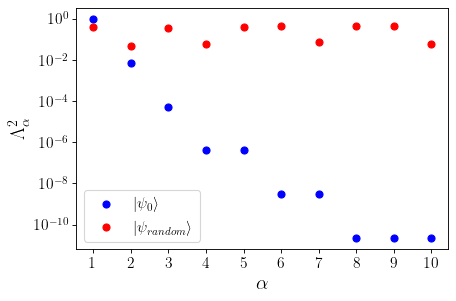

In [17]:
from matplotlib.ticker import MaxNLocator
import os
os.environ["PATH"] += ':/usr/local/texlive/2015/bin/x86_64-darwin'

x = np.arange(1,chi_max+1,1)
slx = np.arange(1,len(sluchaino)+1,1)
fig, ax = plt.subplots(dpi = 80)
#ax = fig.add_subplot(x,lamb[L//2][0:20])
#line, = ax.plot(x, lamb[L//2][0:t], c='b', marker='o')
ax.set_yscale('log')
ax.xaxis.set_major_locator(MaxNLocator(integer=True))

plt.xlabel(r'$\alpha$',fontsize=18)
plt.ylabel(r'$\Lambda_\alpha^2$',fontsize=18)
plt.scatter(x, Lambda[L//2][:chi_max], s=40, c='b', marker='o',label  = r"$|\psi_0 \rangle$")
plt.scatter(slx,sluchaino, s=40, c='r', marker='o',label  = r"$|\psi_{random} \rangle$")
plt.legend(fontsize = 14)
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
plt.tick_params(labelsize=14)
plt.show()
#fig = plt.gcf()
#plt.savefig("nasheto.pdf")